# Advanced introduction

In [1]:
from golem import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(context='talk', style='ticks')

## Uncertainty functions implemented in Golem

Here we plot some of the probability densities readily availale in ``Golem``.

In [3]:
uniform = Uniform(urange=0.2)
normal = Normal(std=0.2)
gamma = Gamma(std=0.2, low_bound=0)
truncated_normal = TruncatedNormal(std=0.2, low_bound=0, high_bound=2)

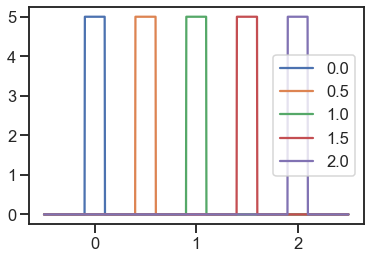

In [4]:
x = np.linspace(-0.5, 2.5, 1000)
locs = np.array([0, 0.5, 1, 1.5, 2])

for loc in locs:
    y = [uniform.pdf(x=xi, loc=loc) for xi in x]
    plt.plot(x, y, label=loc)

plt.legend()

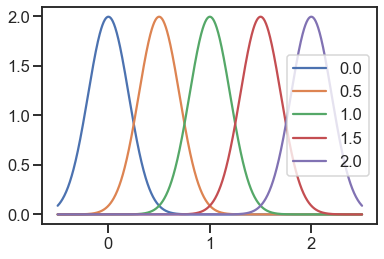

In [5]:
for loc in locs:
    y = [normal.pdf(x=xi, loc=loc) for xi in x]
    plt.plot(x, y, label=loc)

plt.legend()

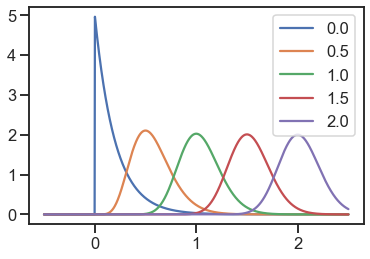

In [6]:
for loc in locs:
    y = [gamma.pdf(x=xi, loc=loc) for xi in x]
    plt.plot(x, y, label=loc)

plt.legend()

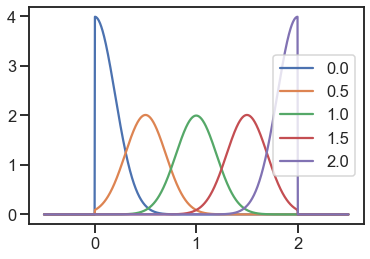

In [7]:
for loc in locs:
    y = [truncated_normal.pdf(x=xi, loc=loc) for xi in x]
    plt.plot(x, y, label=loc)

plt.legend()

## One-dimensional example

In [9]:
def objective(x):

    def sigmoid(x, l, k, x0):
        return l / (1 + np.exp(-k*(x-x0)))

    sigs = [sigmoid(x,  1, 100, 0.1),
            sigmoid(x, -1, 100, 0.2),
            sigmoid(x,  0.7, 80, 0.5),
            sigmoid(x, -0.7, 80, 0.9)
           ]
    return np.sum(sigs, axis=0)

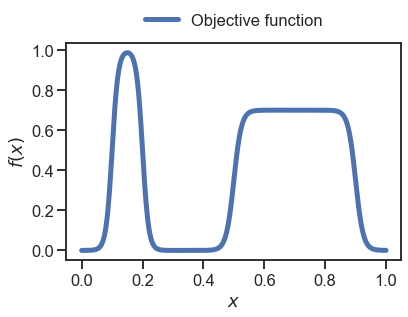

In [10]:
x = np.linspace(0, 1, 1000)
_ = plt.plot(x, objective(x), linewidth=5, label='Objective function')
_ = plt.xlabel('$x$')
_ = plt.ylabel('$f(x)$')
_ = plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5 ,1.), frameon=False)

In [11]:
# we consider 1000 samples in x
x = np.linspace(0, 1, 1000)
y = objective(x)

# initialise Golem
golem = Golem(goal='max', random_state=42, nproc=1)

# fit the Golem surrogate model - note the argument X takes a 2D array, like the sklearn models
golem.fit(X=x.reshape(-1,1), y=y)

# estimate the robust merits for the same 1000 samples
dists = [Normal(std=0.1)]  # ==> input uncertainty
y_robust = golem.predict(X=x.reshape(-1,1), distributions=dists)

[INFO] Golem ... 1 tree(s) parsed in 66.15 ms ...
[INFO] Golem ... Convolution of 1000 samples performed in 20.35 ms ...


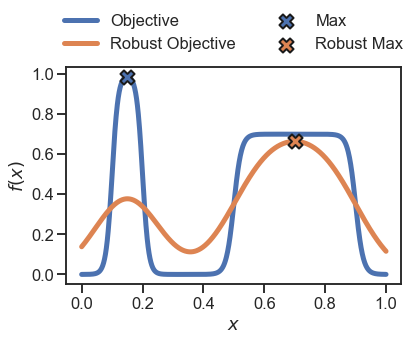

In [12]:
plt.plot(x, y, linewidth=5, label='Objective')
plt.plot(x, y_robust, linewidth=5, label='Robust Objective')

# identidy the max locations
plt.scatter(x[np.argmax(y)], np.max(y), zorder=10, s=200, marker='X', edgecolor='k', label='Max', linewidth=2)
plt.scatter(x[np.argmax(y_robust)], np.max(y_robust), zorder=10, s=200, marker='X',  edgecolor='k', label='Robust Max', linewidth=2)

_ = plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5 ,1.), frameon=False)
_ = plt.xlabel('$x$')
_ = plt.ylabel('$f(x)$')

## Two-dimensional example

In [15]:
def objective2d(x0, x1):        
    fx0 = 10 / (1 + 0.3 * np.exp(6 * x0)) + 0.1 * np.abs(2 * x0**2)
    fx1 = 10 / (1 + 0.3 * np.exp(6 * x1)) + 0.1 * np.abs(2 * x1**2)
    return fx0 + fx1

In [16]:
N = 51
dists = [Normal(1), Normal(1)]

# prepare data grid
x0 = np.linspace(0, 5, N)
x1 = np.linspace(0, 5, N)
X0, X1 = np.meshgrid(x0, x1)
Y = objective2d(X0, X1)

# put into dataframe
Xy = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten(), 'y': Y.flatten()})
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1:]

# compute robust surface
golem = Golem(ntrees=1, random_state=42, nproc=1)
golem.fit(X=X, y=y)
y_robust = golem.predict(X=X, distributions=dists)
Y_robust = np.reshape(y_robust, newshape=np.shape(X0))

[INFO] Golem ... 1 tree(s) parsed in 247.07 ms ...
[INFO] Golem ... Convolution of 2601 samples performed in 728.67 ms ...


In [17]:
def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu_r'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha)
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    # mark minima
    ax.scatter([X0.flatten()[np.argmin(y)]], [X1.flatten()[np.argmin(y)]], 
               s=200, color='white', linewidth=1, edgecolor='k', marker='*', zorder=20)
        
    ax.set_aspect('equal', 'box')
    return mappable

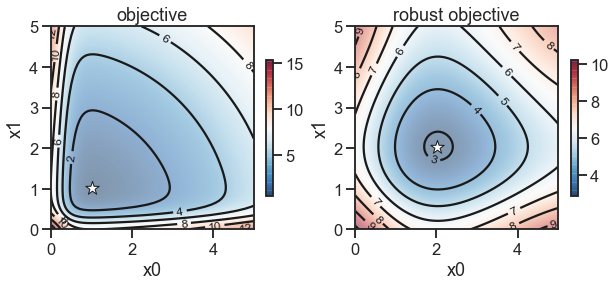

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

_ = plot_contour(ax1, X0, X1, Y, [0, 5], [0, 5], cbar=True)
_ = plot_contour(ax2, X0, X1, Y_robust, [0, 5], [0, 5], cbar=True)

_ = ax1.set_title('objective')
_ = ax2.set_title('robust objective')
_ = ax1.set_xlabel('x0')
_ = ax1.set_ylabel('x1')
_ = ax2.set_xlabel('x0')
_ = ax2.set_ylabel('x1')

## Estimate using a 8x8 grid

In the examples above, we used a very dense grid. However, in practice, one typically has to estimate the robust objective surface from a limited number of evaluations of the objective function. First, we fit ``Golem`` using the 64 available samples...

In [22]:
# we assume normally distributed uncertainty in both dimensions with stddev=1
# You can change this to see how it affects the results, e.g. if you use std=0.1 vs 10
dists = [Normal(std=1), Normal(std=1)]  

N = 8  # ==> use 8x8 grid to fit Golem model...
x0 = np.linspace(0, 5, N)
x1 = np.linspace(0, 5, N)
X0, X1 = np.meshgrid(x0, x1)
Y = objective2d(X0, X1)

# put into dataframe
Xy = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten(), 'y': Y.flatten()})
X_train = Xy.iloc[:, :-1]
y_train = Xy.iloc[:, -1:]

# compute robust surface
golem = Golem(ntrees=1, random_state=42, nproc=1)
golem.fit(X=X_train, y=y_train)

[INFO] Golem ... 1 tree(s) parsed in 4.64 ms ...


...then, we use the ``predict`` method to estimate the whole robust surface.

In [24]:
# ==> now predict whole surface on 100x100 grid
N = 100 

# prepare data grid
x0 = np.linspace(0, 5, N)
x1 = np.linspace(0, 5, N)
X0, X1 = np.meshgrid(x0, x1)
Y = objective2d(X0, X1)

# put into dataframe
X_pred = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

# expectation of the objective
y_robust = golem.predict(X=X_pred, distributions=dists)
Y_robust = np.reshape(y_robust, newshape=np.shape(X0))

# stddev of the objective
y_robust_std = golem.std_robust
Y_robust_std = np.reshape(y_robust_std, newshape=np.shape(X0))

# tree-based surrogate model used by Golem
y_surrogate = golem.forest.predict(X_pred)
Y_surrogate = np.reshape(y_surrogate, newshape=np.shape(X0))

[INFO] Golem ... Convolution of 10000 samples performed in 82.77 ms ...


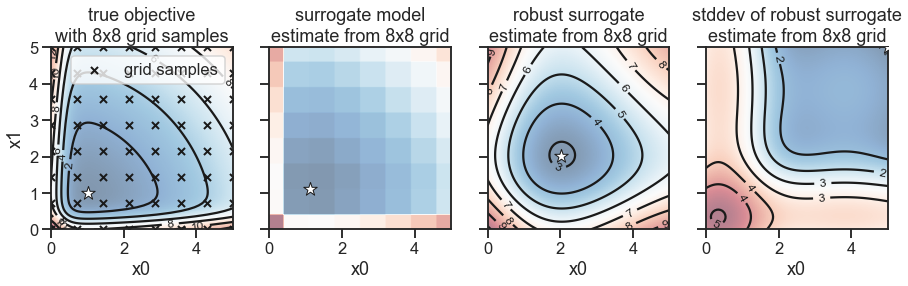

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), sharex=True, sharey=True)

_ = plot_contour(ax1, X0, X1, Y, [0, 5], [0, 5])
_ = plot_contour(ax2, X0, X1, Y_surrogate, [0, 5], [0, 5], contour_lines=False)
_ = plot_contour(ax3, X0, X1, Y_robust, [0, 5], [0, 5])
_ = plot_contour(ax4, X0, X1, Y_robust_std, [0, 5], [0, 5])

ax1.set_title('true objective\nwith 8x8 grid samples')
ax2.set_title('surrogate model\nestimate from 8x8 grid')
ax3.set_title('robust surrogate\nestimate from 8x8 grid')
ax4.set_title('stddev of robust surrogate\nestimate from 8x8 grid')

ax1.scatter(X_train['x0'], X_train['x1'], s=50, marker='x', color='k', linewidth=2, label='grid samples')

_ = ax1.set_xlabel('x0')
_ = ax2.set_xlabel('x0')
_ = ax3.set_xlabel('x0')
_ = ax4.set_xlabel('x0')
_ = ax1.set_ylabel('x1')

_ = ax1.legend()

Description of the 4 plots above, from left to right:

1. 2D surface representing the objective function (blue=better, red=worse). We assume we sampled only 64 points from this surface and we provide this to Golem.

2. ``Golem`` builds a surrogate model of the objective function based on the 64 samples using a tree-based model. In this case, a single regression tree, but one can also choose e.g. random forest.

3. ``Golem`` then uses its surrogate model, together with the specified uncertainty, to "transform" the surrogate into a model of the robust surrogate, which represents the average-case performance of each specific input given the specified uncertainty. We can see that the optimum is shifted away from the "cliff" at low values of ``x0`` and ``x1``.

4. Finally, Golem can also estimate the expected variance/stddev of the output, i.e. how much is the output going to vary if we choose specific ``(x0, x1)`` values (and assuming the specified uncertainty). Here we can see that low values of ``x0`` and  ``x1`` have the higher variance, because we are close to the cliff, while for pretty values of ``x0>2`` and ``x1>2``, one can expect lower output variability.